# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import sys
import inspect
from collections import defaultdict
from contextlib import contextmanager
from itertools import combinations, product
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sys.path.append('..')
from py_graphs.graphs.generator import StochasticBlockModel
from py_graphs.graphs.dataset import football, polbooks, zachary, news_2cl_1, news_2cl_2, news_2cl_3, news_3cl_1, news_3cl_2, news_3cl_3
from py_graphs.measure import *
from py_graphs.measure import H_kernels_plus_RSP_FE
from py_graphs.cluster.ward import Ward
from py_graphs.colors import d3, d3_category20
from py_graphs.scenario import *
from py_graphs.scorer import copeland

In [5]:
def load_or_calc_and_save(filename):
    def my_decorator(func):
        def wrapped():
            if os.path.exists(filename):
                print('File exist! Skip calculations')
                with open(filename, 'rb') as f:
                    result = pickle.load(f)
            else:
                result = func()
                with open(filename, 'wb') as f:
                    pickle.dump(result, f)
            return result
        return wrapped
    return my_decorator

In [6]:
def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

In [7]:
d3_right_order = []
for i in range(6):
    d3_right_order.extend([d3_category20[2*i + 1], d3_category20[2*i]])
d3_right_order.append(d3_category20[12])

## 6. Cluster analysis on several classical datasets

For each dataset and each measure family, we sorted 55 values of the family parameter in the descending order of the
corresponding ARI. ARI against the rank of the family parameter value is shown in Fig. 9.

In [15]:
measures_right_order = [
    'pWalk H',
    'Walk H',
    'For H',
    'logFor H',
    'Comm H',
    'logComm H',
    'Heat H',
    'logHeat H',
    'SCT H',
    'SCCT H',
    'RSP K',
    'FE K',    
    'SP-CT H'
]
all_datasets = [
    football,
    polbooks,
    # polblogs,
    zachary,
#     news_2cl_1, news_2cl_2, news_2cl_3,
#     news_3cl_1, news_3cl_2, news_3cl_3,
#     news_5cl_1, news_5cl_2, news_5cl_3
]


In [16]:
def perform(classic_plot, dataset):
    dataset_results = {}
    graphs, info = dataset
    print(info)
    for measure_class in tqdm(H_kernels_plus_RSP_FE, desc=info['name']):
        x, y, error = classic_plot.perform(Ward, measure_class, graphs, info['k'], n_jobs=1)
        dataset_results[measure_class.name] = (x, y)
    return info['name'], dataset_results


@load_or_calc_and_save('results/6_1.pkl')
def calc():
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=False)
    return dict(Parallel(n_jobs=9)(delayed(perform)(classic_plot, dataset) for dataset in all_datasets))

results = calc()

{'n': 115, 'count': 1, 'k': 12, 'p_in': None, 'name': 'football', 'p_out': None}
{'n': 34, 'count': 1, 'k': 2, 'p_in': None, 'name': 'zachary', 'p_out': None}
{'n': 105, 'count': 1, 'k': 3, 'p_in': None, 'name': 'polbooks', 'p_out': None}


HBox(children=(IntProgress(value=0, description='football', max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, description='polbooks', max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, description='zachary', max=13), HTML(value='')))

polbooks


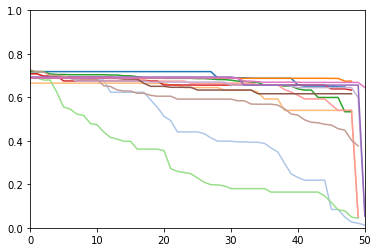

football


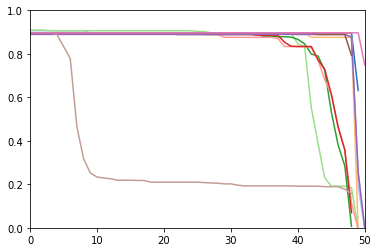

zachary


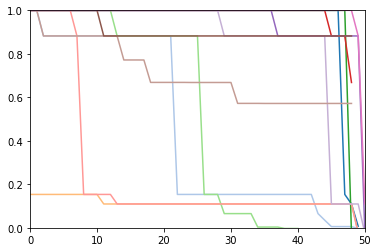

In [17]:
for dataset_name, measure_results in results.items():
    print(dataset_name)
    d3c = (x for x in d3_right_order)
    for measure_name in measures_right_order:
        x, y = measure_results[measure_name]
        plt.plot(range(len(y)), sorted(y, reverse=True), color=d3c.__next__())
    plt.xlim(0, 50)
    plt.ylim(0, 1)
    plt.show()